The goal of the Intelligent Forecasting Competition is to predict consumption (stock_distributed in the Primary Data Dictionary) for 11 contraceptives across 156 health service delivery sites in the public sector health system in Côte d’Ivoire. The predictions should be made monthly for three months: October 2019, November 2019, and December 2019, using the dataset provided. The data field that grantees will be predicting is stock_distributed. The Zindi leaderboard scores predictions for three months: July 2019, August 2019, and September 2019.



Data quality in data sets such as these is a significant issue. For example, not all sites report all data each month. In addition, there are cases in the contraceptive_logistics_data.csv dataset where the Côte d’Ivoire eLMIS system records a '0' value that may in fact represent a "non-reported" value or a value entered by a user for convenience. In such an instance, these ‘0’ values do not reflect actual observed values.

These ‘invalid 0 values’ may be identified, for example, when:

A) All fields (possibly with the exception of stock_ordered) are recorded as '0' for a given contraceptive product, month and service delivery site; or

B) Stock_distributed for a contraceptive product at a service delivery site is reported in a given month as '0', even though stock was available (stock_initial was above 0) and stock_distributed is historically well above 0.

These apparently invalid '0' values have not been cleaned from the primary dataset provided.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
keras = tf.keras

ImportError: Traceback (most recent call last):
  File "c:\users\test\appdata\local\programs\python\python37-32\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 18, in swig_import_helper
    fp, pathname, description = imp.find_module('_pywrap_tensorflow_internal', [dirname(__file__)])
  File "c:\users\test\appdata\local\programs\python\python37-32\lib\imp.py", line 296, in find_module
    raise ImportError(_ERR_MSG.format(name), name=name)
ImportError: No module named '_pywrap_tensorflow_internal'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\test\appdata\local\programs\python\python37-32\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "c:\users\test\appdata\local\programs\python\python37-32\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "c:\users\test\appdata\local\programs\python\python37-32\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 20, in swig_import_helper
    import _pywrap_tensorflow_internal
ModuleNotFoundError: No module named '_pywrap_tensorflow_internal'


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [6]:
# !pip install --upgrade pip

In [4]:
import sys 
sys.executable

'c:\\users\\test\\appdata\\local\\programs\\python\\python37-32\\python.exe'

In [14]:
# !pip install numpy pandas sklearn matplotlib

In [ ]:
!pip uninstall tensorflow

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

NameError: name 'tf' is not defined

In [ ]:
train=pd.read_csv('./data/Train.csv')
sample=pd.read_csv('./data/SampleSubmission.csv')

In [4]:
train.head()

,year,month,region,district,site_code,product_code,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,75,0,21,-54,0,18,0,100.0
1,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,3,0,3,0,0,2,0,10.0
2,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27000,0,75,22,0,53,9,0,0.0
3,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27137,2,0,0,0,2,0,0,0.0
4,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27138,45,0,2,0,43,1,0,0.0


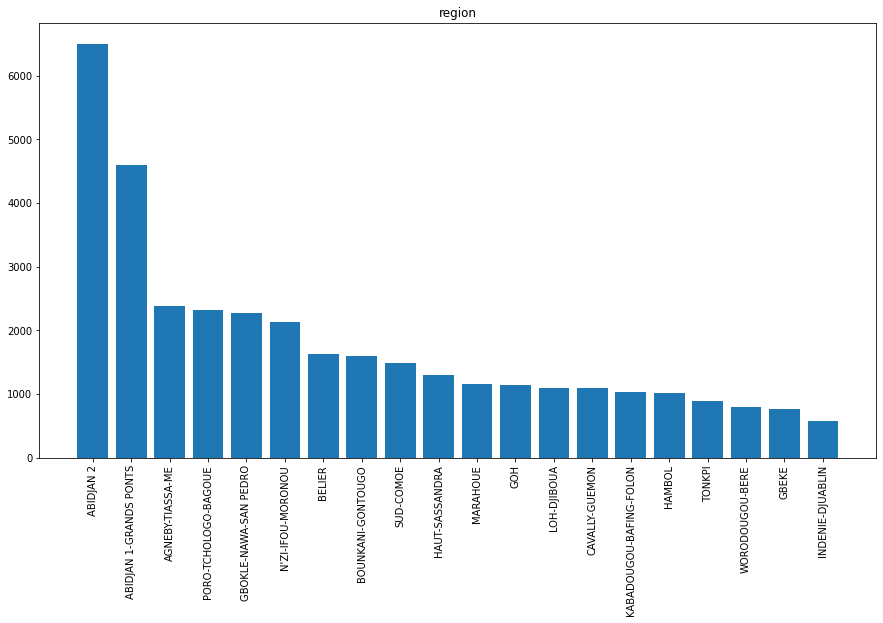

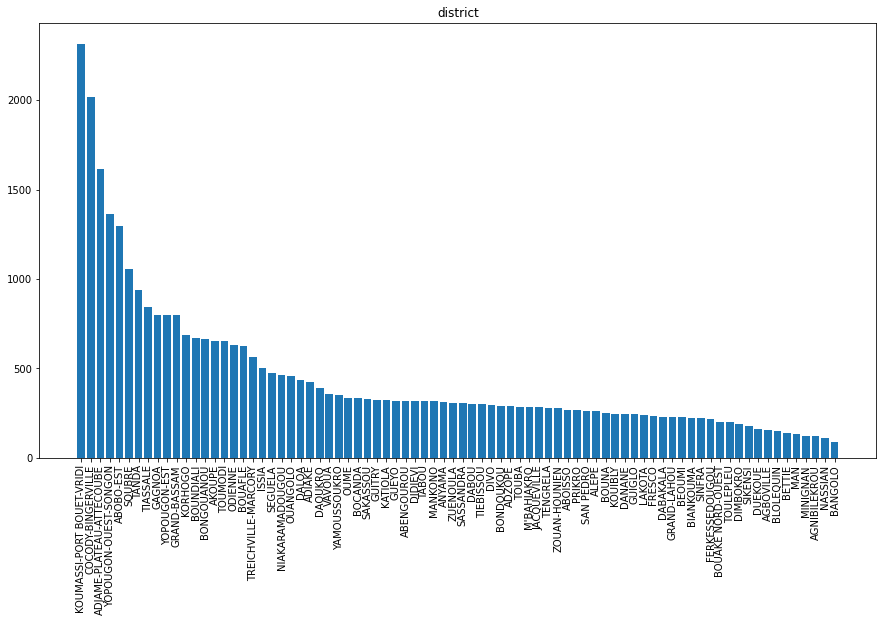

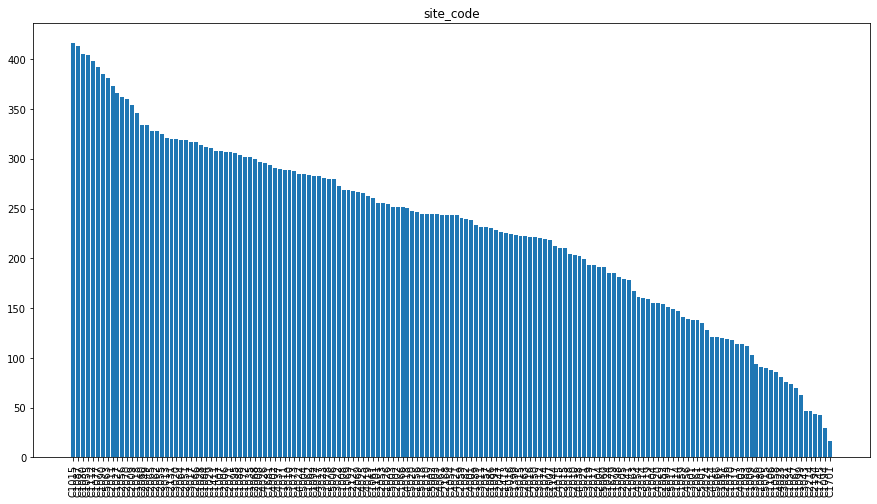

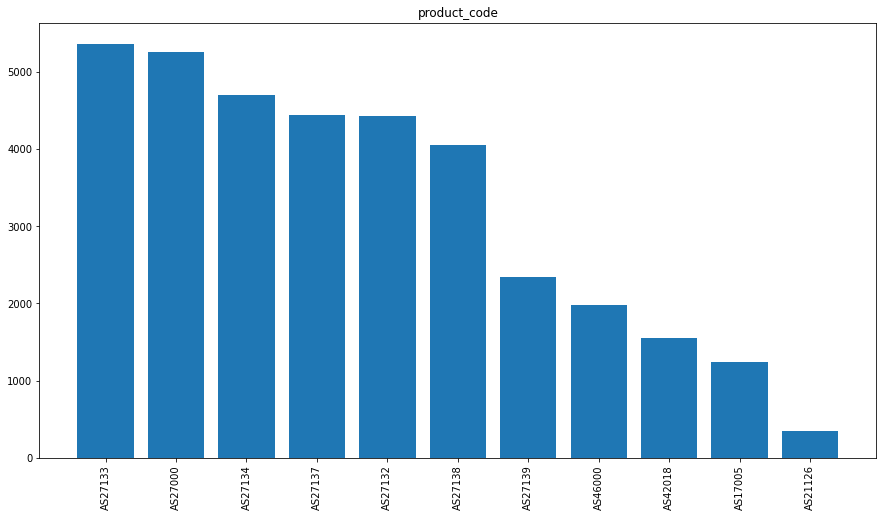

In [5]:
for k in [k for k in train.columns if train[k].dtype==object]:
    coun=train[k].value_counts()
    plt.figure(figsize=(15,8))
    plt.title(k)
    plt.bar(coun.keys(), coun.values)
    plt.xticks(rotation=90)
    plt.show()
    

In [6]:
train.columns

Index(['year', 'month', 'region', 'district', 'site_code', 'product_code',
       'stock_initial', 'stock_received', 'stock_distributed',
       'stock_adjustment', 'stock_end', 'average_monthly_consumption',
       'stock_stockout_days', 'stock_ordered'],
      dtype='object')

Example of sparseness of data

In [7]:
train.site_code.unique()[1]

'C4023'

In [8]:
train.product_code.unique()[3]

'AS27137'

In [9]:
train.loc[(train.site_code==train.site_code.unique()[5]) 
          &(train.product_code==train.product_code.unique()[3])
         ]

,year,month,region,district,site_code,product_code,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered
78,2019,1,ABIDJAN 2,ABOBO-EST,C1063,AS27137,0,0,0,0,0,0,0,10.0
118,2019,2,ABIDJAN 2,ABOBO-EST,C1063,AS27137,0,10,0,0,10,0,0,10.0
146,2019,3,ABIDJAN 2,ABOBO-EST,C1063,AS27137,10,0,10,0,0,3,0,10.0
181,2019,4,ABIDJAN 2,ABOBO-EST,C1063,AS27137,0,0,0,0,0,3,0,10.0
209,2019,5,ABIDJAN 2,ABOBO-EST,C1063,AS27137,0,10,0,0,10,3,0,0.0
253,2019,6,ABIDJAN 2,ABOBO-EST,C1063,AS27137,10,0,0,0,10,0,0,0.0
6329,2018,3,ABIDJAN 2,ABOBO-EST,C1063,AS27137,0,0,0,0,0,0,0,0.0
6364,2018,4,ABIDJAN 2,ABOBO-EST,C1063,AS27137,0,0,0,0,0,0,0,0.0
6398,2018,5,ABIDJAN 2,ABOBO-EST,C1063,AS27137,0,0,0,0,0,0,0,0.0
6457,2018,6,ABIDJAN 2,ABOBO-EST,C1063,AS27137,0,0,0,0,0,0,0,0.0


# How to measure the incompleteness?

In [10]:
train.groupby(["site_code","product_code"]).count().apply(lambda x: x.mean(),axis=1)

site_code  product_code
C1004      AS21126          2.000000
           AS27000         25.000000
           AS27132         24.000000
           AS27133         27.000000
           AS27134         26.000000
                             ...    
C5066      AS27137         25.916667
           AS27138         26.000000
           AS27139          5.916667
           AS42018          5.916667
           AS46000          6.000000
Length: 1343, dtype: float64

## Does very site has  historic of all product? 

In [11]:
print(f'the number of  product is {train.product_code.nunique()}')


the number of  product is 11


In [12]:
train.groupby(["site_code"]).apply(lambda x: x.product_code.nunique()==11).all()

False

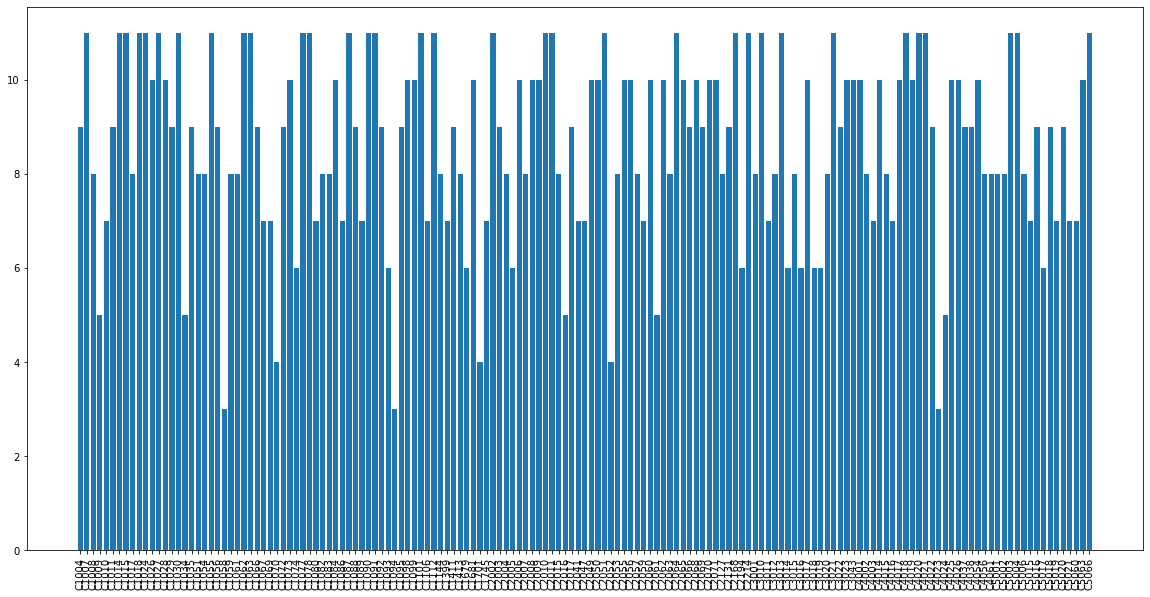

In [13]:
bar_d=train.groupby(["site_code"]).apply(lambda x: x.product_code.nunique())
plt.figure(figsize=(20,10))
plt.bar(bar_d.keys(), bar_d.values)
_=plt.xticks(rotation=90)

## Does all the product we want to predict appear in the correct site? 

In [14]:
sample.ID.apply(lambda x: [[k] for k in x.split(" X ")])
for k in range(4):
    sample[k]=sample.ID.apply(lambda x: x.split(" X ")[k]).values
sample

,ID,prediction,0,1,2,3
0,2019 X 7 X C4001 X AS21126,0,2019,7,C4001,AS21126
1,2019 X 7 X C4001 X AS27134,0,2019,7,C4001,AS27134
2,2019 X 7 X C4001 X AS27132,0,2019,7,C4001,AS27132
3,2019 X 7 X C4001 X AS27000,0,2019,7,C4001,AS27000
4,2019 X 7 X C4001 X AS27137,0,2019,7,C4001,AS27137
...,...,...,...,...,...,...
3084,2019 X 9 X C5076 X AS27000,0,2019,9,C5076,AS27000
3085,2019 X 9 X C5076 X AS27139,0,2019,9,C5076,AS27139
3086,2019 X 9 X C5076 X AS27137,0,2019,9,C5076,AS27137
3087,2019 X 9 X C5076 X AS27138,0,2019,9,C5076,AS27138


In [15]:
sample.drop(['ID'],axis=1, inplace=True)
sample

,prediction,0,1,2,3
0,0,2019,7,C4001,AS21126
1,0,2019,7,C4001,AS27134
2,0,2019,7,C4001,AS27132
3,0,2019,7,C4001,AS27000
4,0,2019,7,C4001,AS27137
...,...,...,...,...,...
3084,0,2019,9,C5076,AS27000
3085,0,2019,9,C5076,AS27139
3086,0,2019,9,C5076,AS27137
3087,0,2019,9,C5076,AS27138


In [16]:
sample.columns=['prediction', "year",'month','site_code','product_code']
sample

,prediction,year,month,site_code,product_code
0,0,2019,7,C4001,AS21126
1,0,2019,7,C4001,AS27134
2,0,2019,7,C4001,AS27132
3,0,2019,7,C4001,AS27000
4,0,2019,7,C4001,AS27137
...,...,...,...,...,...
3084,0,2019,9,C5076,AS27000
3085,0,2019,9,C5076,AS27139
3086,0,2019,9,C5076,AS27137
3087,0,2019,9,C5076,AS27138


In [17]:
sample.groupby(["site_code"]).apply(lambda x: x.product_code.nunique()==11).all()

False

In [18]:
sample.groupby(["site_code"]).apply(lambda x: x.product_code.nunique()==11).sum()

12

In [19]:
# What's the repartition of the length of prediction? 

In [20]:
sample.groupby(['site_code','product_code']).count().prediction.value_counts()

3    1009
1      28
2      17
Name: prediction, dtype: int64

# Let's analyse the site and product targeted. Does that target has enough(length of data) data to predict something. 

In [21]:
# create a id for unique and specific code site and product_id

target_sample=sample[['site_code','product_code']].apply(lambda x: x.site_code+'*'+x.product_code,axis=1).unique()
target_sample

array(['C4001*AS21126', 'C4001*AS27134', 'C4001*AS27132', ...,
       'C5076*AS27137', 'C5076*AS27138', 'C5076*AS27133'], dtype=object)

In [22]:
#count the number of entries in the train 
len_target=pd.Series(target_sample).apply(lambda x: x.split('*'))\
    .apply(lambda x : len(train.loc[(train.site_code==x[0] )& (train.product_code==x[1])]))
len_target

0        3
1       41
2       41
3       41
4       41
        ..
1049     0
1050     0
1051     0
1052     0
1053     0
Length: 1054, dtype: int64

In [23]:
len_target.plot()d

SyntaxError: invalid syntax (<ipython-input-23-e6938f52cfb2>, line 1)

In [ ]:
target_sample.shape

## Very important fact. we see that some target doesn't have historical data because len_target has some zeros even if there is a good density. Let's check a example. 

In [ ]:
len_target

In [ ]:
target_sample[-1]

In [ ]:
train.loc[(train.site_code=='C5076')&(train.product_code=='AS27133')]

That's mean that, we dont just have to predict by historic value but also to deduct other product stock. 

For that purpose we can use a multioutput model, in that way, we could use other historical data to predict product

<h1>What we have to predict ? 
a quantity of product for a given year (YYYY)[not really important]; month (MM); site_code; product_code;

Lets preprocess the data.
<br> Firstly we have to reindex to show empty values. 


Let's do a example.

## What is the interval of time of our dataset.?

In [24]:
pd.to_datetime(train.apply(lambda x : str(x['month'])+'/01/'+str(x['year']),axis=1)).describe()

count                   35753
unique                     42
top       2019-04-01 00:00:00
freq                     1068
first     2016-01-01 00:00:00
last      2019-06-01 00:00:00
dtype: object

##  Preprocessing and dataset definition

In [25]:
target='stock_distributed'
categoric_features=['year','month','region','district','site_code','product_code']
num_features=[k for k in train.columns if k not in categoric_features and k != target]
target, categoric_features,num_features

('stock_distributed',
 ['year', 'month', 'region', 'district', 'site_code', 'product_code'],
 ['stock_initial',
  'stock_received',
  'stock_adjustment',
  'stock_end',
  'average_monthly_consumption',
  'stock_stockout_days',
  'stock_ordered'])

In [26]:
# [f'{k}_{i}' for k in  data.columns for i in range(window_size)]

In [27]:
#width of past values fed to the model to predict futur
window_size=5
# to preserve the orginal value(think about it a procedural programming like in Big Data)
data=train.copy()
# original features that will be shifted... (;-)
org_col=data.columns



def prep(frame,window_size,org_col=org_col,target=target):
    
    if len(frame)>=window_size:
#         for past features (not include zero because if will be redondant with the actual values or org_cols)
        for i in range(1,window_size):
            frame[[f'{k}_{i}' for k in org_col]]=frame[org_col].shift(i)
        for m in range(1,4):
            frame[f'{target}+{m}']=frame[target].shift(-m)

    else:
        print('not enough data')
        return frame
    frame.fillna(method='median')
    return frame


for k in [f'{k}_{i}' for k in  data.columns for i in range(1,window_size)] \
                                +[f'{target}+{i}' for i in range(1,4)]:
    data[k]=np.nan
data=data.groupby(['site_code','product_code']).apply(lambda x: prep(x,window_size) )
data

not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enough data
not enou

,year,month,region,district,site_code,product_code,stock_initial,stock_received,stock_distributed,stock_adjustment,...,stock_stockout_days_2,stock_stockout_days_3,stock_stockout_days_4,stock_ordered_1,stock_ordered_2,stock_ordered_3,stock_ordered_4,stock_distributed+1,stock_distributed+2,stock_distributed+3
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,75,0,21,-54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0
1,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,3,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27000,0,75,22,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,10.0,7.0
3,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27137,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0
4,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27138,45,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,9.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35748,2016,7,LOH-DJIBOUA,GUITRY,C2055,AS27133,0,50,25,0,...,0.0,0.0,0.0,0.0,25.0,2.0,25.0,NaN,NaN,NaN
35749,2016,7,LOH-DJIBOUA,GUITRY,C2055,AS27138,150,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
35750,2016,7,LOH-DJIBOUA,GUITRY,C2055,AS27132,1,10,4,0,...,0.0,0.0,0.0,0.0,10.0,10.0,10.0,NaN,NaN,NaN
35751,2016,7,LOH-DJIBOUA,GUITRY,C2055,AS27134,8,0,8,0,...,0.0,0.0,0.0,0.0,25.0,0.0,50.0,NaN,NaN,NaN


In [40]:
#handle missing values and missing target. 
data=data.loc[  ( ~data['stock_distributed+1'].isnull())& ( ~ data['stock_distributed+2'].isnull()) &\
         ( ~data['stock_distributed+3'].isnull())]




In [41]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('dark')
from sklearn import preprocessing
from scipy.stats import skew, boxcox
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [42]:
target, categoric_features,num_features

('stock_distributed',
 ['year', 'month', 'region', 'district', 'site_code', 'product_code'],
 ['stock_initial',
  'stock_received',
  'stock_adjustment',
  'stock_end',
  'average_monthly_consumption',
  'stock_stockout_days',
  'stock_ordered'])

In [50]:
categoric_features_=[f'{k}_{i}' for k in categoric_features for i in range(1,window_size)]+categoric_features
num_features_=[f'{k}_{i}' for k in num_features for i in range(1,window_size)]+num_features
targets=[f'{target}+{i}' for i in range(1,4)]+[target]
categoric_features_,num_features_,targets

(['year_1',
  'year_2',
  'year_3',
  'year_4',
  'month_1',
  'month_2',
  'month_3',
  'month_4',
  'region_1',
  'region_2',
  'region_3',
  'region_4',
  'district_1',
  'district_2',
  'district_3',
  'district_4',
  'site_code_1',
  'site_code_2',
  'site_code_3',
  'site_code_4',
  'product_code_1',
  'product_code_2',
  'product_code_3',
  'product_code_4',
  'year',
  'month',
  'region',
  'district',
  'site_code',
  'product_code'],
 ['stock_initial_1',
  'stock_initial_2',
  'stock_initial_3',
  'stock_initial_4',
  'stock_received_1',
  'stock_received_2',
  'stock_received_3',
  'stock_received_4',
  'stock_adjustment_1',
  'stock_adjustment_2',
  'stock_adjustment_3',
  'stock_adjustment_4',
  'stock_end_1',
  'stock_end_2',
  'stock_end_3',
  'stock_end_4',
  'average_monthly_consumption_1',
  'average_monthly_consumption_2',
  'average_monthly_consumption_3',
  'average_monthly_consumption_4',
  'stock_stockout_days_1',
  'stock_stockout_days_2',
  'stock_stockout_day

In [ ]:
def generate_pipeline(model,num_feat, cat_feat):
    # We create the preprocessing pipelines for both numeric and categorical data.

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant'), value=0),
        ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_feat),
            ('cat', categorical_transformer, cat_feat)])
    
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
    return clf

In [48]:
# commun_columns=['year','month','region','district','site_code','product_code']

# df=train.loc[(train.site_code==train.site_code.unique()[5]) 
# #           &(train.product_code==train.product_code.unique()[3])
#          ].copy()
# time_frame=df.apply(lambda x : str(x['month'])+'/01/'+str(x['year']),axis=1)
# time_frame,pd.to_datetime(time_frame)
# df['date']=pd.to_datetime(time_frame).values

# dd=df.groupby('product_code').apply(lambda x: x.set_index('date').reindex(pd.date_range('1/1/2016','6/1/2019', freq='MS', normalize=True)))
# # df.set_index('date').reindex(pd.date_range('1/1/2016','6/1/2019', freq='MS', normalize=True))
# dd=dd.unstack(level=0)
# col_list= [' '.join(col).strip() for col in dd.columns.values]
# dd.columns = col_list

# dd=dd[[k for k in dd.columns if len([l for l in commun_columns if l in k])==0]]
# dd

In [126]:
# windows_size=5
# def check_continuity(x):
#     print(len(x))
# #     print(type(x.values[0]))
#     if np.nan in x.values:
# #         print(x)
#         return False
#     else:
        
#         return True

# index_available= dd['stock_distributed AS17005'].rolling(5,min_periods=5).apply(check_continuity, raw=False)

In [35]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=10):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#     dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
#     dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def preprocessing(site_code, product_code):
    target='stock_distributed'
    train_country=train.loc[(train.site_code==site_code) &(train.product_code==product_code),'stock_distributed'].values
    scaler=MinMaxScaler(feature_range=(0.,1))
    train_country=scaler.fit_transform(train_country.reshape(-1,1)).reshape(1,-1)[0]
       
    #splitting training data 2/3 for the training part and 1/3 of the part 
    split_data=int(2*train_country.shape[0]/3)
    series_train=train_country[:split_data]
    series_validation=train_country[split_data:]
    print('the length for the specific dataset ',len(train_country))    
    print('the length of training set is ',series_train.shape,'and the lenght of the validation set is ',series_validation.shape)
    return [ series_train,series_validation,scaler]

def define_model(k=100):
    
    model = keras.models.Sequential([
      keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          input_shape=[None]),
      keras.layers.LSTM(k, return_sequences=True,
                         input_shape=[None, 1]),
      keras.layers.LSTM(k, ),
#       keras.layers.Dense(100),
    #       keras.layers.SimpleRNN(1),
    #       keras.layers.SimpleRNN(100, return_sequences=True),
    #       keras.layers.SimpleRNN(100),
            keras.layers.Dense(1),
#           keras.layers.Lambda(lambda x: x * 500.0)
        ])
    return model
def define_deeper_model(num_country):
    inputs_country=tf.keras.layers.Input(shape=(1,))
    inputs_sequentials=tf.keras.layers.Input(shape=(1,))
    sequential_model=define_model()(inputs_sequentials)
    country_layers=tf.keras.layers.Embedding(num_country,32,embeddings_initializer=tf.keras.initializers.GlorotNormal)(inputs_country)
    add=tf.keras.layers.concatenate([country_layers,sequential_model])
    dens=tf.keras.layers.Dense(10)(add)
    output=tf.keras.layers.Dense(1)
    return tf.keras.Models(inputs=[inputs_sequential,inputs_coutry],outputs=output)
    

def sequential_window_dataset(series, window_size,forward_step=7):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(  window_size + forward_step, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + forward_step))
    ds = ds.map(lambda window: (window[:-forward_step], window[window_size:]))
    return ds

class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

def preprocessing_all_data(window_size,shuffle_buffer,batch_size=100,use_all=False):
    enc=LabelEncoder()
    enc.fit(train.Territory.unique())
    if use_all:
        split=train.shape[0] # no validation data 
    else:
        split=int(2*(train.loc[train.Territory=='China','target'].shape[0])/3)
        
    series=train.loc[train.Territory=='China','target'].values
    toscale=train.target.values
    scaler=MinMaxScaler(feature_range=(0,1))
    
    scaler.fit(toscale.reshape(-1,1))
    series=scaler.transform(series.reshape(-1,1)).reshape(1,-1)[0]
    
    dataset_train=window_dataset(series[:split],window_size,enc.transform(['China'])[0])
    dataset_validation=window_dataset(series[split:],window_size,enc.transform(['China'])[0])
    
    for country in train.Territory.unique():
        series=train.loc[train.Territory==country,'target'].values
        series=scaler.transform(series.reshape(-1,1)).reshape(1,-1)[0]
        #create a datset for one country
        dataset_train_country=window_dataset(series[:split],window_size,enc.transform([country])[0])
        dataset_validation_country=window_dataset(series[split:],window_size,enc.transform([country])[0])
        #concatenate in the stack
        dataset_train=dataset_train.concatenate(dataset_train_country)
        data_validation=dataset_validation.concatenate(dataset_validation_country)
        
    dataset_train=dataset_train.batch(batch_size).prefetch(100)
    dataset_validation=dataset_validation.batch(batch_size).prefetch(100)
    return [dataset_train,dataset_validation,scaler]